# Census Population Data (2020) + NYC Tree Census Data (2015)

### Tress per square mile (by Census Tract) 

### MANHATTAN

In [2]:
# load libraries
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import pysal as ps
import libpysal
import esda
from pysal.lib import weights
from splot.esda import plot_moran
from splot.esda import plot_local_autocorrelation

In [3]:
# read in data
trees_cts = gpd.read_file("data/trees_cts.geojson")

In [4]:
trees_cts.head()

,GEOID,population,census tract,county,tree_count,trees_per_capita,area_per_sqmile,trees_per_sqmile,geometry
0,36005012701,1664.0,127.01,Bronx,201.0,0.120793,0.041620,4829.377806,"POLYGON ((-7129744.449 4787818.802, -7129654.2..."
1,36005037300,4365.0,373,Bronx,211.0,0.048339,0.066843,3156.671549,"POLYGON ((-7129604.833 4789904.712, -7129520.2..."
2,36005011900,4276.0,119,Bronx,247.0,0.057764,0.063114,3913.558552,"POLYGON ((-7129505.357 4787665.982, -7129427.7..."
3,36005039100,5255.0,391,Bronx,364.0,0.069267,0.079709,4566.636743,"POLYGON ((-7129221.590 4790683.165, -7129136.5..."
4,36005007900,4957.0,79,Bronx,297.0,0.059915,0.076384,3888.228621,"POLYGON ((-7131068.335 4786855.710, -7130944.4..."


In [5]:
# check county names
print(trees_cts['county'].drop_duplicates().to_list())

['Bronx', 'Kings', 'Queens', 'Richmond', 'New York']


In [7]:
# look at only Brooklyn
MH_trees_sqmile = trees_cts.query("county == 'New York'")

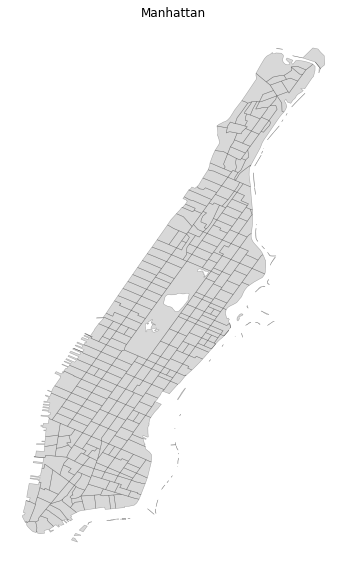

In [70]:
# check plot

# create a figure with one subplot
fig, ax = plt.subplots(figsize=(20,10))

# plot census tracts
MH_trees_sqmile.plot(ax = ax, alpha = 0.3, edgecolor = 'black', linewidth = 0.5, color = 'gray')

ax.axis('off')
ax.set(title = 'Manhattan')

plt.savefig("maps/Manhattan/Manhattan_CTs.pdf")

In [9]:
# first - drop cells containing Null values (cells containing zero points) - or code will not work
MH_trees_sqmile = MH_trees_sqmile.dropna(subset = ['trees_per_sqmile'])

In [10]:
# drop trees per capita with 0
MH_trees_sqmile = MH_trees_sqmile.query("trees_per_sqmile > 0")

In [11]:
# create queen contiguity weights
w_MH = weights.Queen.from_dataframe(MH_trees_sqmile)

In [13]:
# fill in islands with KNN weights
w_knn_MH = weights.KNN.from_dataframe(MH_trees_sqmile, k=1)

In [14]:
w_MH = weights.attach_islands(w_MH, w_knn_MH)

There are no disconnected observations (no islands)!


In [15]:
# row standardize weights
w_MH.transform = 'R'

## Spatial Autocorrelation - Local Moran's I
### *removed all census tracts with 0 trees per square mile*

In [16]:
# on trees per capita
local_moran_MH = esda.moran.Moran_Local(MH_trees_sqmile['trees_per_sqmile'], w_MH)

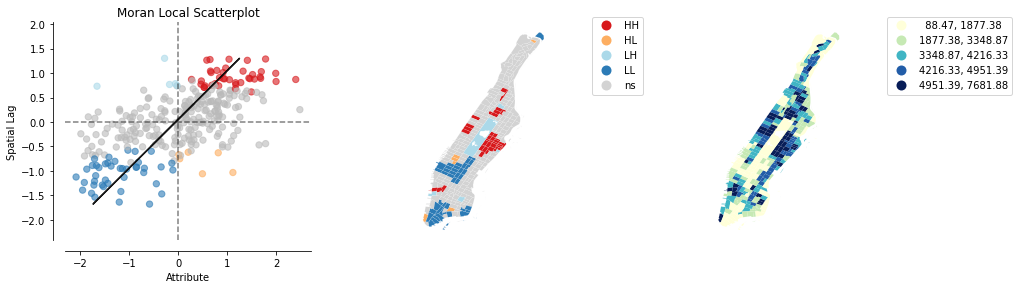

In [17]:
# plot results (at p < 0.05)
plot_local_autocorrelation(local_moran_MH, MH_trees_sqmile,'trees_per_sqmile', p = 0.05 );

plt.savefig("maps/Manhattan/Manhattan_Trees-per-SquareMile_moran.pdf")

In [18]:
# get clusters and outliers - adding columns to the DF

MH_trees_sqmile['local_moran_Is'] = local_moran_MH.Is
MH_trees_sqmile['local_moran_p_value'] = local_moran_MH.p_sim
MH_trees_sqmile['local_moran_quadrant'] = local_moran_MH.q

In [19]:
# get statisically significant clusters and outliers

alpha = 0.05
hotspots_MH = MH_trees_sqmile.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots_MH = MH_trees_sqmile.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts_MH = MH_trees_sqmile.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamonds_MH = MH_trees_sqmile.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

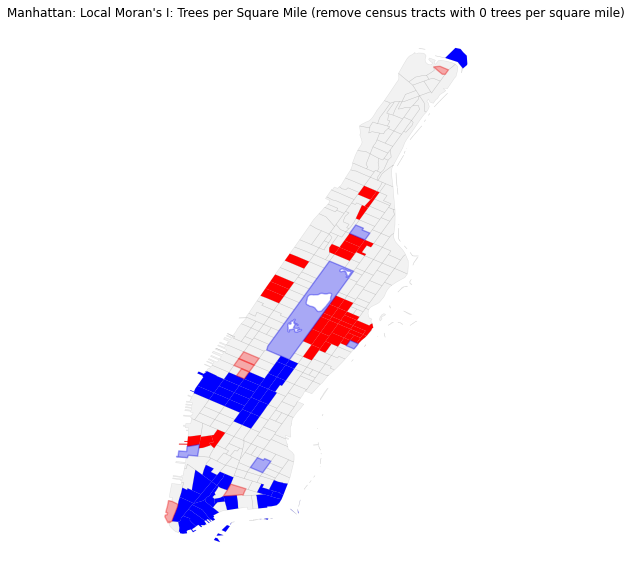

In [20]:
# view clusters and outliers

# create a figure with one subplot
fig, ax = plt.subplots(figsize=(20,10))

# plot census tracts
MH_trees_sqmile.plot(ax = ax, alpha = 0.1, edgecolor = 'black', linewidth = 0.5, color = 'gray')

# plot HH / LL / HL / LH
MH_trees_sqmile.plot(ax = ax, facecolor = 'none', alpha = 0)
hotspots_MH.plot(color = 'red', ax = ax, label = 'Hot Spot')
coldspots_MH.plot(color = 'blue', ax = ax, label = 'Cold Spot')
doughnuts_MH.plot(color = 'blue', alpha = 0.3, edgecolor = 'blue', linewidth = 1.5, ax = ax, label = 'Doughnuts')
diamonds_MH.plot(color = 'red', alpha = 0.3, edgecolor = 'red', linewidth = 1.5, ax = ax, label = 'Diamonds')

ax.axis('off')
ax.set(title = "Manhattan: Local Moran's I: Trees per Square Mile (remove census tracts with 0 trees per square mile)")

plt.savefig("maps/Manhattan/Manhattan_Trees-per-SquareMile.pdf")

### *investigate the numbers*

In [49]:
# look at smallest values
MH_trees_sqmile['trees_per_sqmile'].nsmallest(n=10)

1077     88.470076
1583    250.854777
1963    309.303979
1846    368.390189
406     373.497997
1660    445.534891
120     452.020785
629     494.313731
1575    503.731855
392     610.084155
Name: trees_per_sqmile, dtype: float64

In [51]:
# look at largest values
MH_trees_sqmile['trees_per_sqmile'].nlargest(n=10)

157     7681.879290
376     7541.947705
777     6874.007411
1569    6863.395312
395     6519.472347
1595    6517.959921
1696    6445.618811
718     6395.912068
1081    6373.418911
634     6350.872474
Name: trees_per_sqmile, dtype: float64

In [23]:
# lowest 1% of data
print(MH_trees_sqmile['trees_per_sqmile'].quantile(q = 0.01))

368.4923453905268


In [24]:
# lowest 5% of data
print(MH_trees_sqmile['trees_per_sqmile'].quantile(q = 0.05))

714.3764347050327


In [25]:
# lowest 10% of data
print(MH_trees_sqmile['trees_per_sqmile'].quantile(q = 0.10))

1061.379506350606


In [26]:
# lowest 20% of data
print(MH_trees_sqmile['trees_per_sqmile'].quantile(q = 0.20))

1877.3793047795236


In [27]:
# highest 1% of data
print(MH_trees_sqmile['trees_per_sqmile'].quantile(q = 0.99))

6856.516852961283


In [28]:
# highest 5% of data
print(MH_trees_sqmile['trees_per_sqmile'].quantile(q = 0.95))

6031.0311373558325


In [29]:
# highest 10% of data
print(MH_trees_sqmile['trees_per_sqmile'].quantile(q = 0.90))

5500.270317630961


In [30]:
# highest 20% of data
print(MH_trees_sqmile['trees_per_sqmile'].quantile(q = 0.80))

4951.391467751143


## Spatial Autocorrelation - Local Moran's I - limited
### *removed all census tracts with less than 500 and more than 6,000  trees per square mile*

In [35]:
# limit the range
MH_trees_sqmile_limit = MH_trees_sqmile.query("trees_per_sqmile > 500 & trees_per_sqmile < 6000")

In [36]:
# create queen contiguity weights
w_MH2 = weights.Queen.from_dataframe(MH_trees_sqmile_limit)

In [38]:
# fill in islands with KNN weights
w_knn_MH2 = weights.KNN.from_dataframe(MH_trees_sqmile_limit, k=1)

In [39]:
w_MH2 = weights.attach_islands(w_MH2, w_knn_MH2)

There are no disconnected observations (no islands)!


In [40]:
# row standardize weights
w_MH2.transform = 'R'

In [41]:
# on trees per capita
local_moran_MH2 = esda.moran.Moran_Local(MH_trees_sqmile_limit['trees_per_sqmile'], w_MH2)

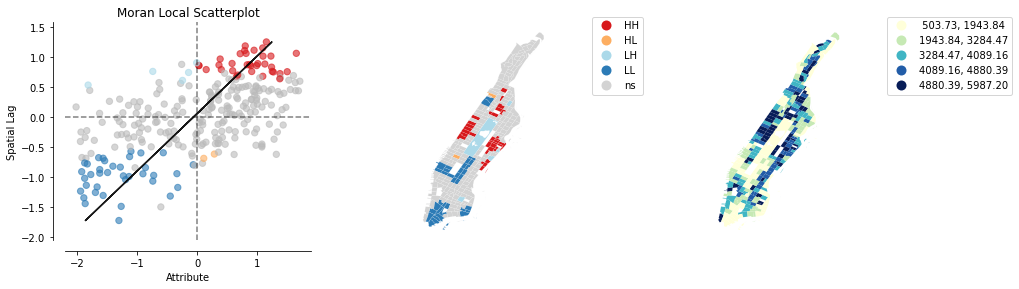

In [43]:
# plot results (at p < 0.05)
plot_local_autocorrelation(local_moran_MH2, MH_trees_sqmile_limit,'trees_per_sqmile', p = 0.05 );

plt.savefig("maps/Manhattan/Manhattan_Trees-per-SquareMile_limited_moran.pdf")

In [45]:
# get clusters and outliers
MH_trees_sqmile_limit['local_moran_Is'] = local_moran_MH2.Is
MH_trees_sqmile_limit['local_moran_p_value'] = local_moran_MH2.p_sim
MH_trees_sqmile_limit['local_moran_quadrant'] = local_moran_MH2.q

In [46]:
# get statisically significant clusters and outliers
alpha = 0.05
hotspots_MH2 = MH_trees_sqmile_limit.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots_MH2 = MH_trees_sqmile_limit.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts_MH2 = MH_trees_sqmile_limit.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamonds_MH2 = MH_trees_sqmile_limit.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

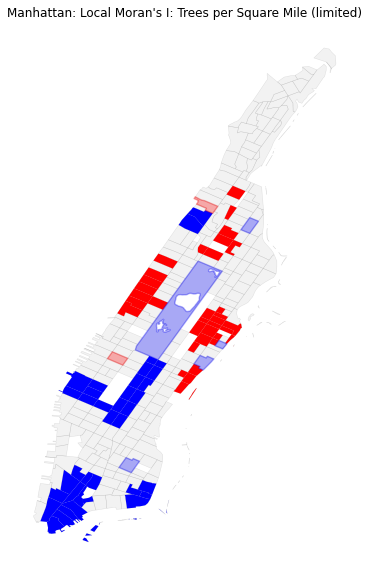

In [47]:
# view clusters and outliers

# create a figure with one subplot
fig, ax = plt.subplots(figsize=(20,10))

# plot census tracts
MH_trees_sqmile_limit.plot(ax = ax, alpha = 0.1, edgecolor = 'black', linewidth = 0.5, color = 'gray')

# plot HH / LL / HL / LH
MH_trees_sqmile_limit.plot(ax = ax, facecolor = 'none', alpha = 0)
hotspots_MH2.plot(color = 'red', ax = ax, label = 'Hot Spot')
coldspots_MH2.plot(color = 'blue', ax = ax, label = 'Cold Spot')
doughnuts_MH2.plot(color = 'blue', alpha = 0.3, edgecolor = 'blue', linewidth = 1.5, ax = ax, label = 'Doughnuts')
diamonds_MH2.plot(color = 'red', alpha = 0.3, edgecolor = 'red', linewidth = 1.5, ax = ax, label = 'Diamonds')

ax.axis('off')
ax.set(title = "Manhattan: Local Moran's I: Trees per Square Mile (limited)")

plt.savefig("maps/Manhattan/Manhattan_Trees-per-SquareMile_limited.pdf")

## Spatial Autocorrelation - Local Moran's I - more limited
### *removed all census tracts with less than 700 and more than 5,000  trees per square mile*

In [55]:
# limit the range
MH_trees_sqmile_limit_more = MH_trees_sqmile_limit.query("trees_per_sqmile > 700 & trees_per_sqmile < 5000")

In [56]:
# create queen contiguity weights
w_MH3 = weights.Queen.from_dataframe(MH_trees_sqmile_limit_more)

In [58]:
# fill in islands with KNN weights
w_knn_MH3 = weights.KNN.from_dataframe(MH_trees_sqmile_limit_more, k=1)

In [59]:
w_MH3 = weights.attach_islands(w_MH3, w_knn_MH3)

There are no disconnected observations (no islands)!


In [60]:
# row standardize weights
w_MH3.transform = 'R'

In [61]:
# on trees per capita
local_moran_MH3 = esda.moran.Moran_Local(MH_trees_sqmile_limit_more['trees_per_sqmile'], w_MH3)

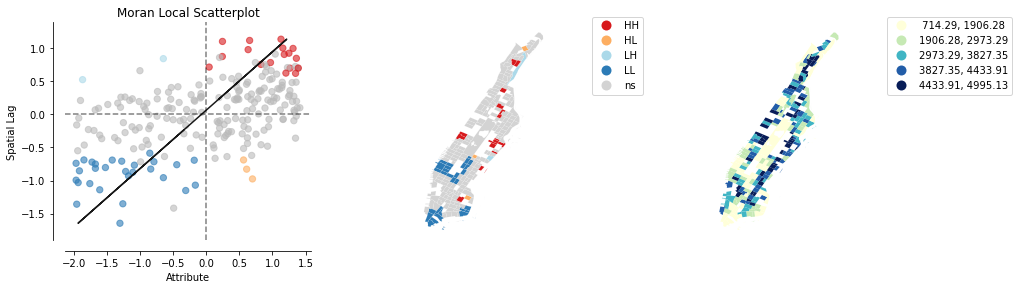

In [63]:
# plot results (at p < 0.05)
plot_local_autocorrelation(local_moran_MH3, MH_trees_sqmile_limit_more,'trees_per_sqmile', p = 0.05 );

plt.savefig("maps/Manhattan/Manhattan_Trees-per-SquareMile_more-limited_moran.pdf")

In [66]:
# get clusters and outliers
MH_trees_sqmile_limit_more['local_moran_Is'] = local_moran_MH3.Is
MH_trees_sqmile_limit_more['local_moran_p_value'] = local_moran_MH3.p_sim
MH_trees_sqmile_limit_more['local_moran_quadrant'] = local_moran_MH3.q

In [68]:
# get statisically significant clusters and outliers
alpha = 0.05
hotspots_MH3 = MH_trees_sqmile_limit_more.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots_MH3 = MH_trees_sqmile_limit_more.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts_MH3 = MH_trees_sqmile_limit_more.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamonds_MH3 = MH_trees_sqmile_limit_more.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

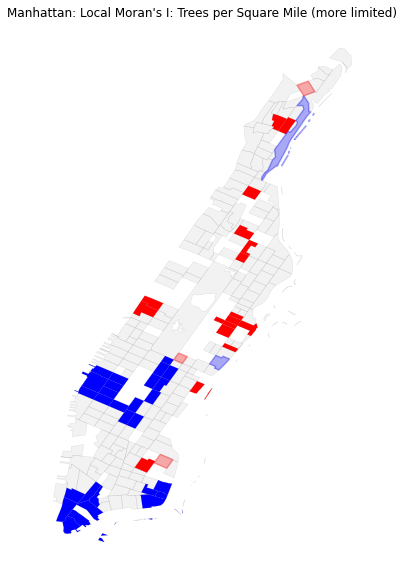

In [69]:
# view clusters and outliers

# create a figure with one subplot
fig, ax = plt.subplots(figsize=(20,10))

# plot census tracts
MH_trees_sqmile_limit_more.plot(ax = ax, alpha = 0.1, edgecolor = 'black', linewidth = 0.5, color = 'gray')

# plot HH / LL / HL / LH
MH_trees_sqmile_limit_more.plot(ax = ax, facecolor = 'none', alpha = 0)
hotspots_MH3.plot(color = 'red', ax = ax, label = 'Hot Spot')
coldspots_MH3.plot(color = 'blue', ax = ax, label = 'Cold Spot')
doughnuts_MH3.plot(color = 'blue', alpha = 0.3, edgecolor = 'blue', linewidth = 1.5, ax = ax, label = 'Doughnuts')
diamonds_MH3.plot(color = 'red', alpha = 0.3, edgecolor = 'red', linewidth = 1.5, ax = ax, label = 'Diamonds')

ax.axis('off')
ax.set(title = "Manhattan: Local Moran's I: Trees per Square Mile (more limited)")

plt.savefig("maps/Manhattan/Manhattan_Trees-per-SquareMile_more-limited.pdf")